# Pipeline 2 - Stockfish engine evaluation

## Inputs
- The extracted files from previous pipeline 1

## Output
- A csv file

## CSV file columns
For each row of the csv file, the output contains:
- **Basic game info**
    - WhiteUsername
    - BlackUsername
    - WhiteElo
    - BlackElo
    - EloDifference
    - TimeControl
    - Opening
    - GameId
- **Moving info**
    - MoveId
    - RemainingTime
    - MovePlayed
    - MovePlayedEval
    - ProcessTime
    - NumberofNodes
- **Algorithm prediction** ($n$ from $1$ to $5$)
    - best_move_$n$,
    - best_score_$n$,
    - ProcessTime_$n$,
    - NumberofNodes_$n$,

WhiteUsername,BlackUsername,WhiteElo,BlackElo,EloDifference,TimeControl,Opening,GameId,
MoveId,RemainingTime,MovePlayed,MovePlayedEval,ProcessTime,NumberofNodes,

best_move_1,best_score_1,ProcessTime_1,NumberofNodes_1,
best_move_2,best_score_2,ProcessTime_2,NumberofNodes_2,
best_move_3,best_score_3,ProcessTime_3,NumberofNodes_3,
best_move_4,best_score_4,ProcessTime_4,NumberofNodes_4,
best_move_5,best_score_5,ProcessTime_5,NumberofNodes_5

---

## Import APIs

In [52]:
# import julia libraries
using PyCall
using CSV
using DataFrames
using Plots

# import python chess library
@pyimport chess
cp = pyimport("chess.pgn")
ce = pyimport("chess.engine")

PyObject <module 'chess.engine' from '/home/ubuntu/.local/lib/python3.10/site-packages/chess/engine.py'>

## Path

In [3]:
# Constants
const STOCKFISH_PATH = "/usr/local/bin/stockfish"

const DATA_PATH = "./data/"
const INPUT_DATA_PATH = "$(DATA_PATH)pipeline1_exported/" # file type: .pgn and .csv file
const OUTPUT_DATA_PATH = "$(DATA_PATH)pipeline2_exported/" # file type: .csv file

const TEMPLATE_FILE_PATH = "$(DATA_PATH)expected_output_template.csv"

# Variables
INPUT_FILENAME = ".pgn"
OUTPUT_FILENAME = ".csv"

"./data/expected_output_template.csv"

In [5]:
# Test file paths
const TEST_INPUT_PATH = "./pre-pipeline-test/"
const TEST_OUTPUT_PATH = "./"

const TEST_INPUT_FILENAME = "$(TEST_INPUT_PATH)test1000.pgn"
const TEST_OUTPUT_FILENAME = "$(TEST_OUTPUT_PATH)test_output.csv"

"./test_output.csv"

## Methods

In [28]:
function initialize_stockfish(STOCKFISH_PATH)
    stockfish = ce.SimpleEngine.popen_uci(STOCKFISH_PATH)
    return stockfish
end
stockfish = initialize_stockfish(STOCKFISH_PATH)

PyObject <SimpleEngine (pid=5771)>

In [114]:
pgn_file = open(TEST_INPUT_FILENAME)
game = cp.read_game(pgn_file)

PyObject <Game at 0x7fa29ecb7a30 ('slammayjammay' vs. 'Zedward', '2023.09.01' at 'https://lichess.org/kLKqVm2U')>

In [22]:
function basic_game_info(game)
    headers = game.headers

    WhiteUsername = get(headers, "White", "NA")
    BlackUsername = get(headers, "Black", "NA")
    WhiteElo = parse(Int64, get(headers, "WhiteElo", "0"))
    BlackElo = parse(Int64, get(headers, "BlackElo", "0"))
    EloDifference = WhiteElo - BlackElo
    TimeControl = get(headers, "TimeControl", "NA")
    Opening = get(headers, "Opening", "NA")
    GameId = split(get(headers, "Site", "NA"), "/")[end]

    basic_game_info = DataFrame(WhiteUsername = [WhiteUsername],
                   BlackUsername = [BlackUsername],
                   WhiteElo = [WhiteElo],
                   BlackElo = [BlackElo],
                   EloDifference = [EloDifference],
                   TimeControl = [TimeControl],
                   Opening = [Opening],
                   GameId = [GameId])

    return basic_game_info
end

basic_game_info (generic function with 1 method)

In [89]:
basic_game_info(game)

Row,WhiteUsername,BlackUsername,WhiteElo,BlackElo,EloDifference,TimeControl,Opening,GameId
,String,String,Int64,Int64,Int64,String,String,SubStrin…
1,slammayjammay,Zedward,1982,1979,3,60+0,Sicilian Defense: Old Sicilian,kLKqVm2U


- **Moving info**
    - MoveId
    - RemainingTime
    - MovePlayed
    - MovePlayedEval
    - ProcessTime
    - NumberofNodes
- **Algorithm prediction** ($n$ from $1$ to $5$)
    - best_move_$n$,
    - best_score_$n$,
    - ProcessTime_$n$,
    - NumberofNodes_$n$,

--

- Clock: `[%clk ...]`
- Eval: `[%eval ...]`

In [72]:
function moving_info(game)
    # Get the current node (latest move played in the game)
    current_node = game.next()

    # MoveId: Assuming this is the ID of the move in the game
    MoveId = current_node.ply()

    # MovePlayed: The move leading to the current node
    # Using UCI notation for the move, you can also use .san() for standard algebraic notation
    MovePlayed = current_node.move.uci()

    # RemainingTime: Retrieve the remaining time after the move
    RemainingTime = current_node.clock()

    MovePlayedEval = nothing
    
    ProcessTime = nothing
    NumberofNodes = nothing
    # ProcessTime = best_move_analysis[1]["time"]
    # NumberofNodes = best_move_analysis[1]["nodes"]

    return game, MoveId, RemainingTime, MovePlayed, MovePlayedEval, ProcessTime, NumberofNodes
end

# function moving_info(game)
#     MoveId
#     RemainingTime
#     MovePlayed
#     MovePlayedEval
#     ProcessTime
#     NumberofNodes
# end

moving_info (generic function with 1 method)

In [116]:
analysis_results = stockfish.analyse(game.board(), ce.Limit(depth=22), multipv=5)
analysis_results

5-element Vector{Dict{Any, Any}}:
 Dict("string" => "NNUE evaluation using nn-0000000000a0.nnue", "time" => 1.561, "tbhits" => 0, "hashfull" => 354, "depth" => 22, "nodes" => 920605, "multipv" => 1, "score" => PyObject PovScore(Cp(+42), WHITE), "pv" => PyObject[PyObject Move.from_uci('d2d4'), PyObject Move.from_uci('e7e6'), PyObject Move.from_uci('e2e4'), PyObject Move.from_uci('d7d5'), PyObject Move.from_uci('b1c3'), PyObject Move.from_uci('g8f6'), PyObject Move.from_uci('e4e5'), PyObject Move.from_uci('f6d7'), PyObject Move.from_uci('f2f4'), PyObject Move.from_uci('c7c5')  …  PyObject Move.from_uci('f3d4'), PyObject Move.from_uci('f8c5'), PyObject Move.from_uci('e2f3'), PyObject Move.from_uci('c5d4'), PyObject Move.from_uci('e3d4'), PyObject Move.from_uci('c6d4'), PyObject Move.from_uci('d1d4'), PyObject Move.from_uci('e8g8'), PyObject Move.from_uci('c3e2'), PyObject Move.from_uci('a6a5')], "seldepth" => 34…)
 Dict("depth" => 22, "nodes" => 920605, "multipv" => 2, "score" => PyObject

In [61]:
prediction(game.board())[1]

(PyObject Move.from_uci('e2e4'), PyObject PovScore(Cp(+41), WHITE), 0.057, 35995)

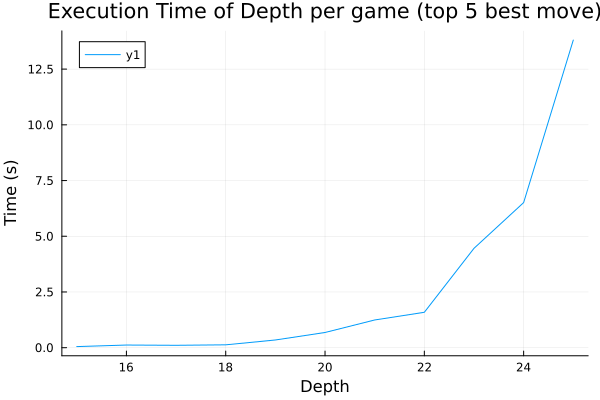

In [111]:
function measure_execution_time(n)
    start_time = time()
    best_move = stockfish.analyse(game.board(), ce.Limit(depth=n), multipv=5)
    end_time = time()

    return end_time - start_time
end

depths = 15:25
execution_times = Float64[]

for n in depths
    push!(execution_times, measure_execution_time(n))
end

plot(depths, execution_times, xlabel="Depth", ylabel="Time (s)", title="Execution Time of Depth per game (top 5 best move)")


In [112]:
execution_times

11-element Vector{Float64}:
  0.0485990047454834
  0.11851978302001953
  0.10687398910522461
  0.12837600708007812
  0.3457000255584717
  0.6825039386749268
  1.2434840202331543
  1.5888400077819824
  4.458656072616577
  6.51146388053894
 13.804327011108398

In [48]:
function prediction(board)
    # Initialize a list to store the predictions
    predictions = []

    # Analyze the board with a depth of 20 and multipv set to 5
    analysis_results = stockfish.analyse(board, ce.Limit(depth=20), multipv=5)

    # Iterate through the analysis results
    for result in analysis_results
        # Extract relevant information from each result
        best_move = result["pv"][1]  # First move in the principal variation
        best_score = result["score"]
        process_time = result["time"]
        number_of_nodes = result["nodes"]

        # Append the extracted information to the predictions list
        push!(predictions, (best_move, best_score, process_time, number_of_nodes))
    end

    return predictions
end


prediction (generic function with 1 method)

In [57]:
function analyze_game(game, stockfish)
    # Get basic game information
    basic_info = basic_game_info(game)

    # Get moving information
    move_info = moving_info(game)

    # Generate predictions
    predictions = prediction(game.board())

    # Create a DataFrame for the game analysis
    game_analysis_data = copy(basic_info)

    # Add moving information to the DataFrame
    game_analysis_data[!, :MoveId] = [move_info[1]]
    game_analysis_data[!, :RemainingTime] = [move_info[2]]
    game_analysis_data[!, :MovePlayed] = [move_info[3]]
    game_analysis_data[!, :MovePlayedEval] = [move_info[4]]
    game_analysis_data[!, :ProcessTime] = [move_info[5]]
    game_analysis_data[!, :NumberofNodes] = [move_info[6]]

    # Add prediction data to the DataFrame
    for i in 1:length(predictions)
        game_analysis_data[!, Symbol("best_move_$i")] = [predictions[i][1]]
        game_analysis_data[!, Symbol("best_score_$i")] = [predictions[i][2]]
        game_analysis_data[!, Symbol("ProcessTime_$i")] = [predictions[i][3]]
        game_analysis_data[!, Symbol("NumberofNodes_$i")] = [predictions[i][4]]
    end

    return game_analysis_data
end


function process_games(file_path, stockfish)
    pgn_file = open(file_path)
    game_data = DataFrame()

    while true
        game = cp.read_game(pgn_file)
        if game === nothing
            break
        end

        game_analysis_data = analyze_game(game, stockfish)
        append!(game_data, game_analysis_data)
    end

    close(pgn_file)
    return game_data
end

function main()
    stockfish = initialize_stockfish(STOCKFISH_PATH)
    file_path = TEST_INPUT_FILENAME  # or other PGN file path
    analyzed_data = process_games(file_path, stockfish)
    CSV.write(TEST_OUTPUT_FILENAME, analyzed_data)
end

main()


LoadError: InterruptException:

## Execution

In [7]:
main()

"test_output.csv"